In [2]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_text
from sklearn.metrics import precision_score, recall_score, auc
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, chi2
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from scipy import stats
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


## Part A. Predicting Bank Marketing Campaign Outcomes


In [7]:
# Part A. Predicting Bank Marketing Campaign Outcomes
# b) Perform Exploratory Data Analysis (EDA)
# 1. Loading the Dataset
# 2. Understading the Dataset

data = pd.read_csv('bank.csv', delimiter=';') 
print("data summary")
print(data.describe())
print()
print(data.info())

data summary
               age       balance          day     duration     campaign  \
count  4521.000000   4521.000000  4521.000000  4521.000000  4521.000000   
mean     41.170095   1422.657819    15.915284   263.961292     2.793630   
std      10.576211   3009.638142     8.247667   259.856633     3.109807   
min      19.000000  -3313.000000     1.000000     4.000000     1.000000   
25%      33.000000     69.000000     9.000000   104.000000     1.000000   
50%      39.000000    444.000000    16.000000   185.000000     2.000000   
75%      49.000000   1480.000000    21.000000   329.000000     3.000000   
max      87.000000  71188.000000    31.000000  3025.000000    50.000000   

             pdays     previous  
count  4521.000000  4521.000000  
mean     39.766645     0.542579  
std     100.121124     1.693562  
min      -1.000000     0.000000  
25%      -1.000000     0.000000  
50%      -1.000000     0.000000  
75%      -1.000000     0.000000  
max     871.000000    25.000000  

<cla

### Data pre-processing

In [8]:
# 3. Handling Missing and Null Values

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Check for null values
print("\nNull Values:")
print(data.isna().sum())


Missing Values:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Null Values:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [9]:
# 4. Handling Duplicates
# Check for duplicated rows
duplicated_rows = data[data.duplicated()]

# Get the number of duplicated rows
num_duplicated_rows = len(duplicated_rows)

# Print the number of duplicated rows
print("Number of duplicated rows:", num_duplicated_rows)

Number of duplicated rows: 0


Number of outliers detected: 2824


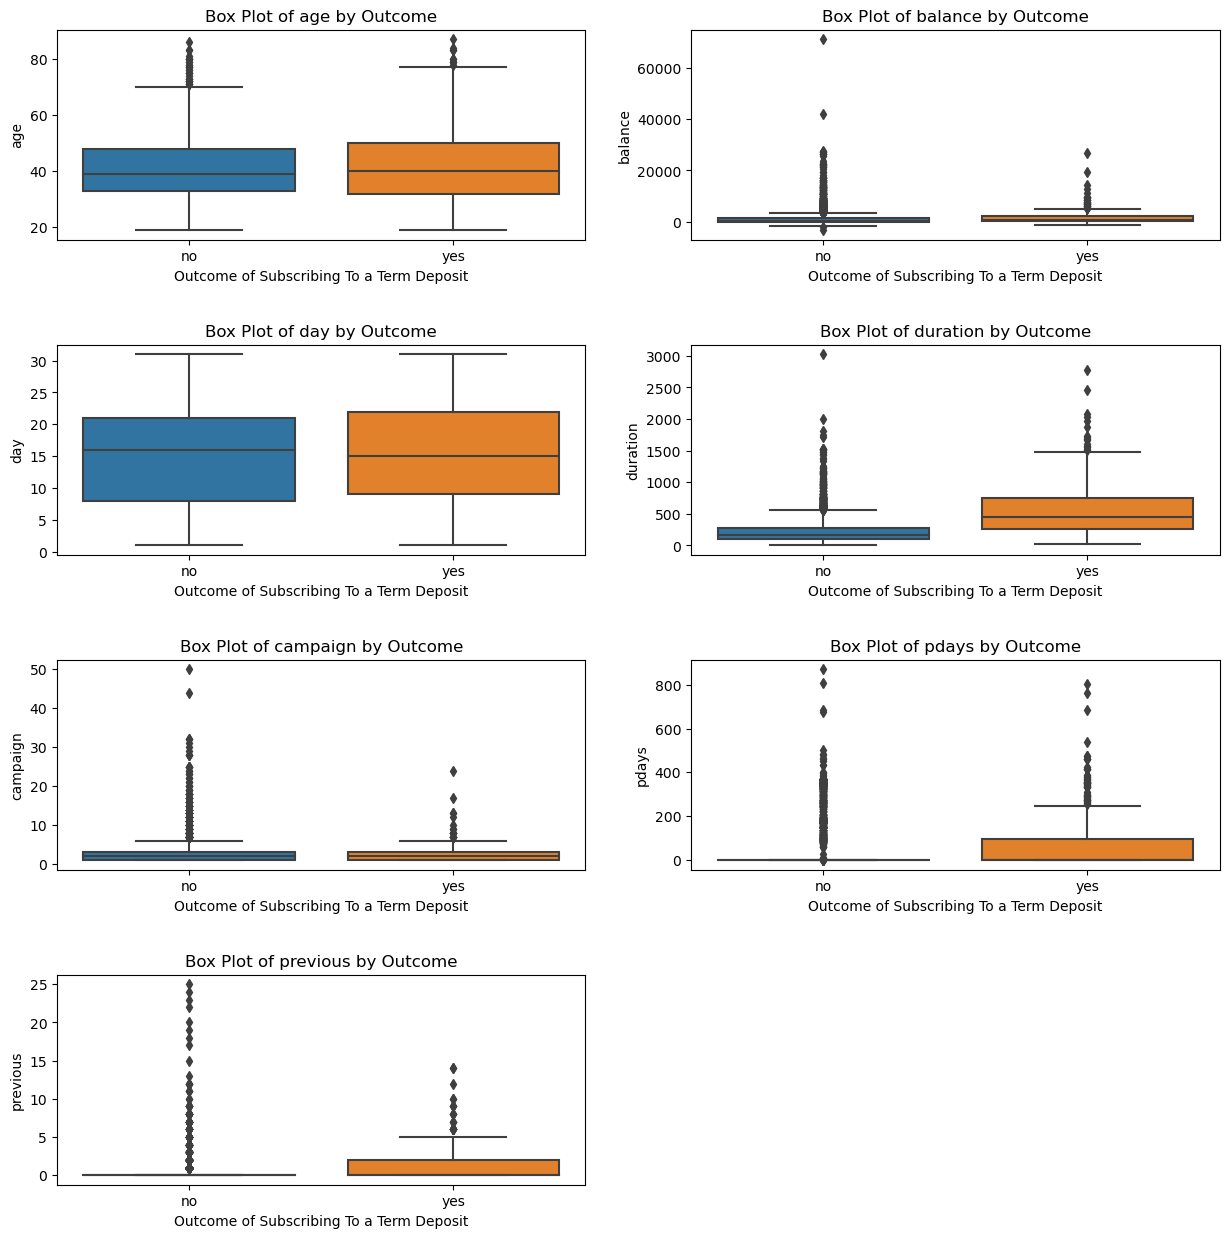

In [10]:
# 5. Outlier Detection and Treatment for numerical attributes
# Get the numerical attributes
numerical_attributes = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Counting outliers
def detect_outliers(df, features):
    outlier_indices = []
    for feature in features:
        Q1 = np.percentile(df[feature], 25)
        Q3 = np.percentile(df[feature], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_count = len(outlier_indices)
    return outlier_indices, outlier_count

outliers_indices, outliers_count = detect_outliers(data, numerical_attributes)
print(f"Number of outliers detected: {outliers_count}")

# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)

# Loop through numerical attributes and create box plots
for i, attribute in enumerate(numerical_attributes):
    row = i // 2
    col = i % 2
    sns.boxplot(x='y', y=attribute, data=data, ax=axes[row, col])
    axes[row, col].set_title(f'Box Plot of {attribute} by Outcome')
    axes[row, col].set_xlabel('Outcome of Subscribing To a Term Deposit')
    axes[row, col].set_ylabel(attribute)

# Remove any empty subplots
if len(numerical_attributes) % 2 != 0:
    fig.delaxes(axes[len(numerical_attributes) // 2, 1])

plt.show()

In [11]:
# 6. Handling “unknown” data in categorical columns.

# Handle "unknown" values
def handle_unknown(data):
    data['education'] = data['education'].replace('unknown', 'no education')
    data['job'] = data['job'].replace('unknown', 'no mention')
    data['contact'] = data['contact'].replace('unknown', 'other')
    data['poutcome'] = data['poutcome'].replace('unknown', 'no record')
    return data

data = handle_unknown(data)

### Data analyse

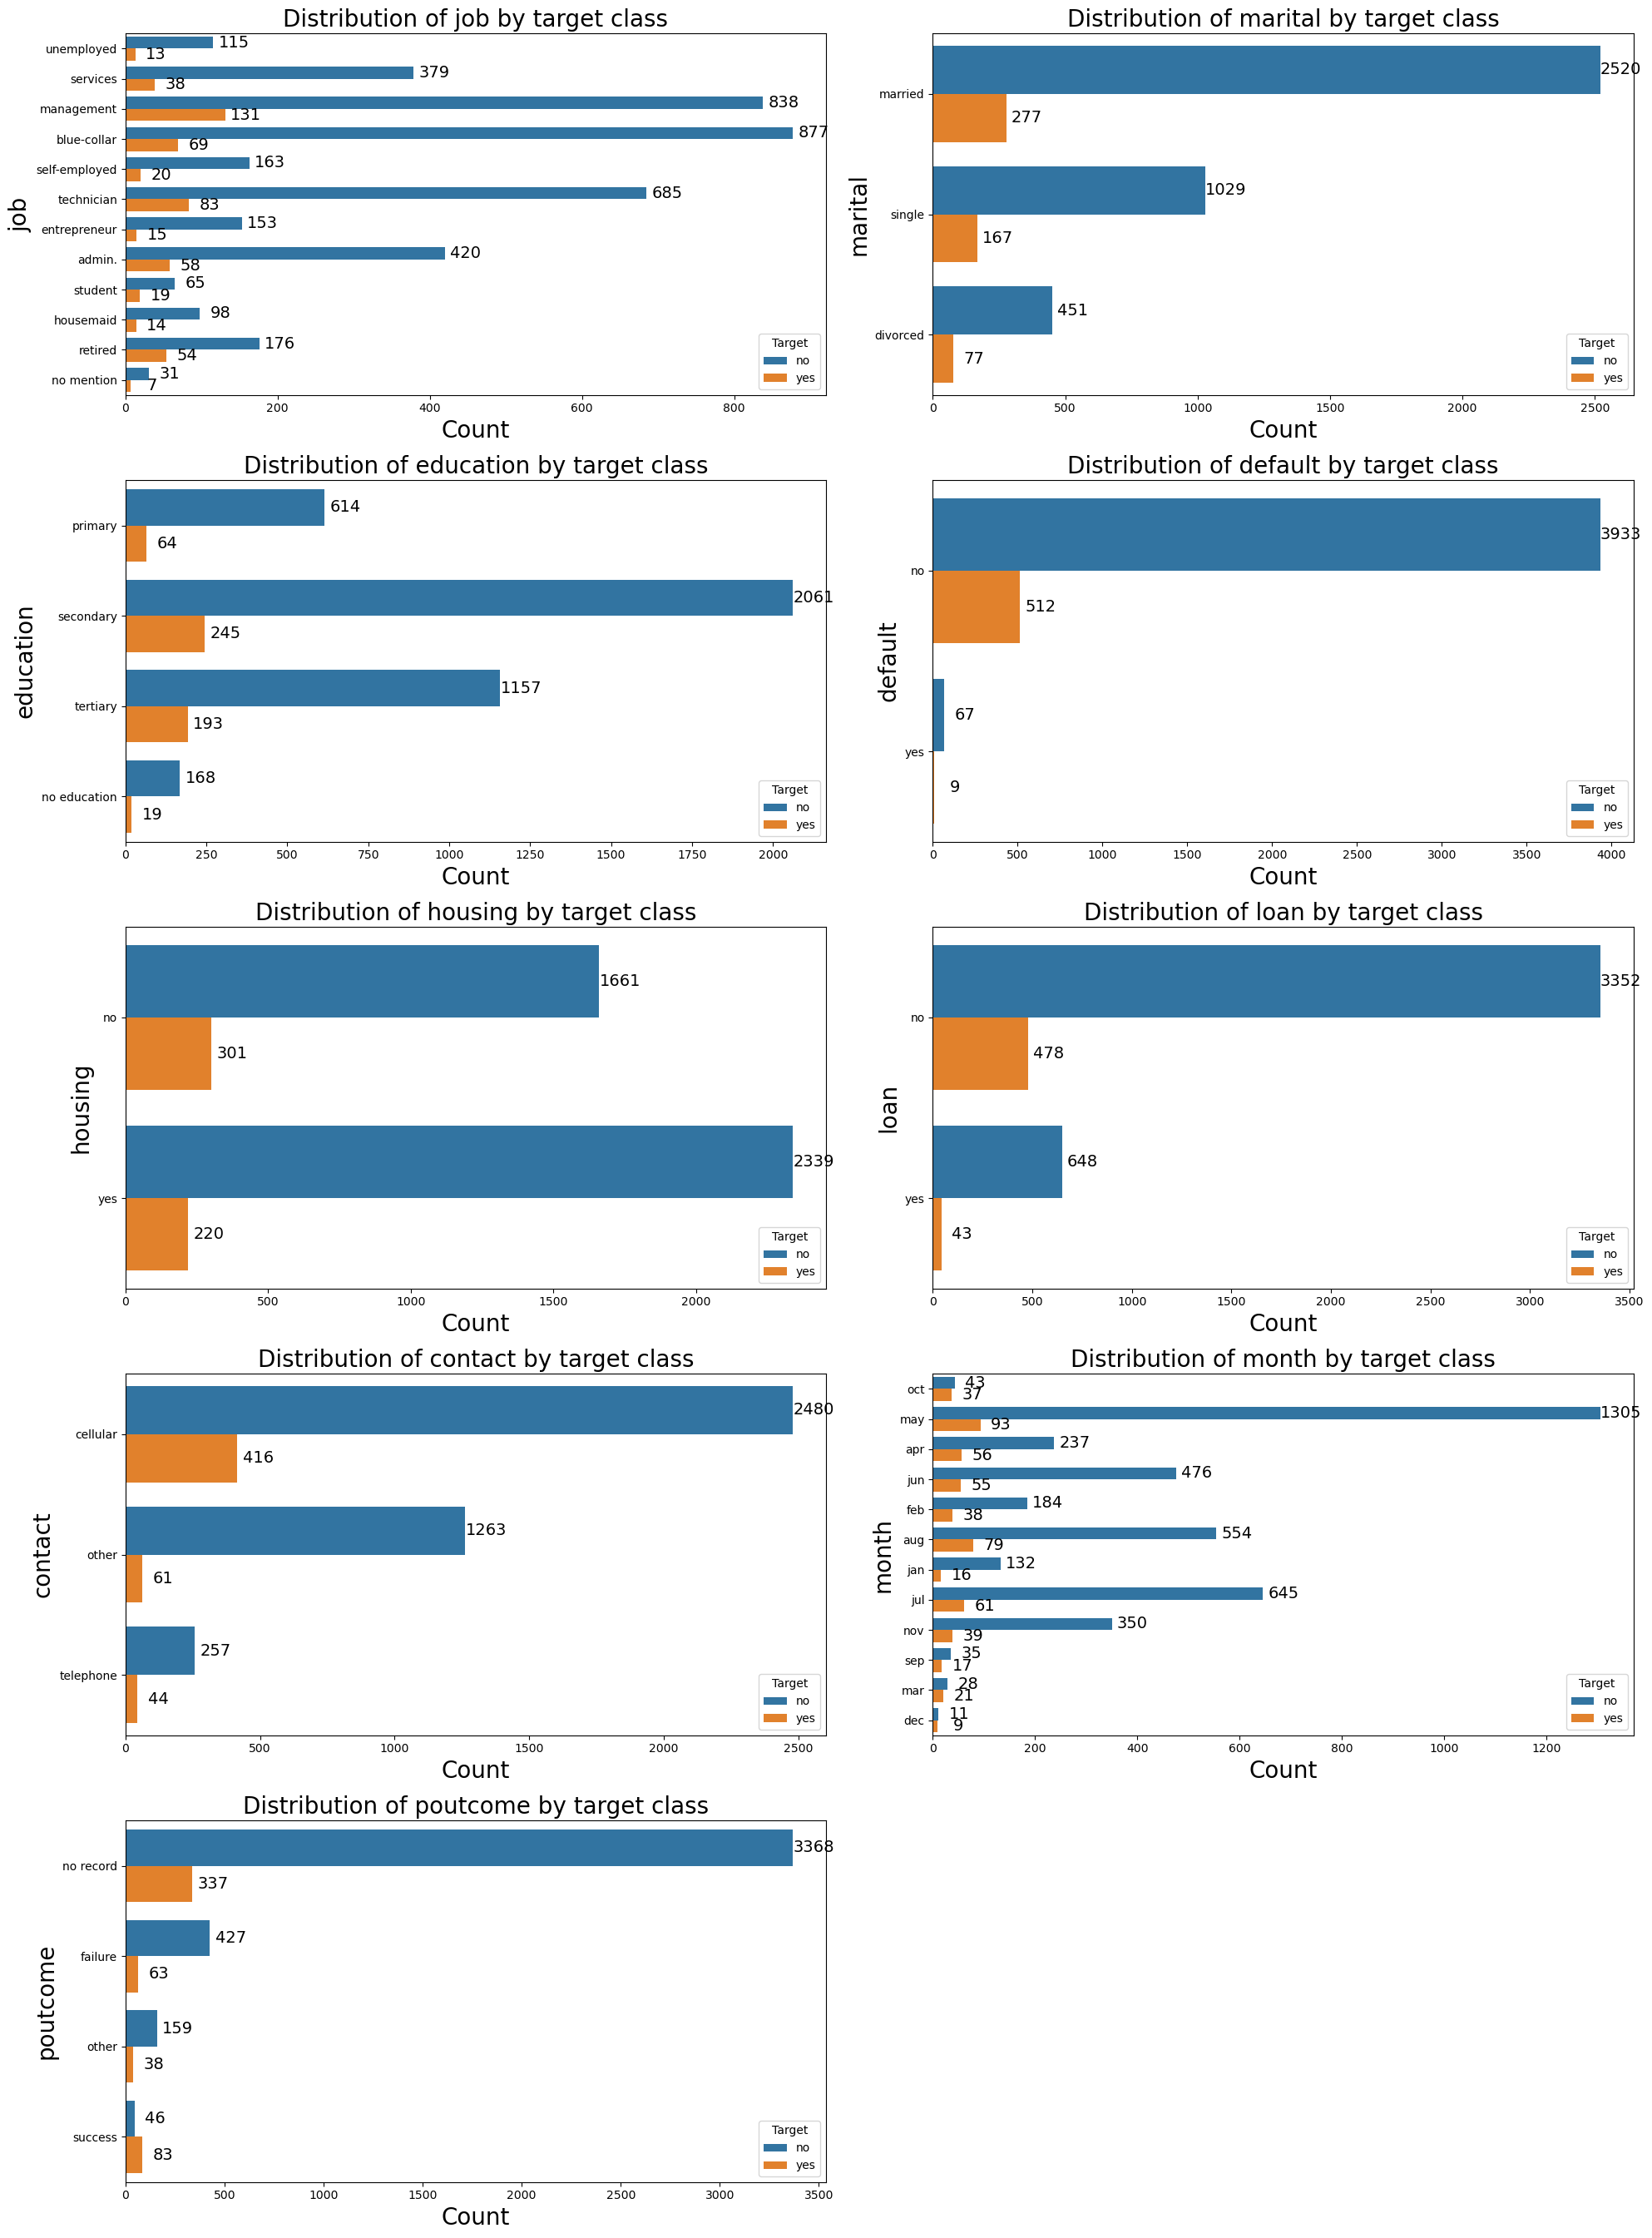

In [12]:
# 7. Exploring Relationships 
# Define categorical attributes and the target class
categorical_attributes = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Set up subplots in a grid with 2 columns
num_plots = len(categorical_attributes)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 27))

# Plot distribution of each categorical attribute
for i, attribute in enumerate(categorical_attributes):
    row = i // num_cols
    col = i % num_cols
    ax = sns.countplot(y=attribute, hue='y', data=data, ax=axes[row, col])
    ax.set_title(f'Distribution of {attribute} by target class', fontsize=20)
    ax.set_xlabel('Count', fontsize=20)
    ax.set_ylabel(attribute, fontsize=20)
    ax.legend(title='Target', loc='lower right')
    
    # Annotate each bar with count value
    for p in ax.patches:
        count = int(p.get_width())
        ax.annotate(f'{count}', (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='center', va='center', fontsize=14, color='black', xytext=(18, 0),
                    textcoords='offset points')

# Remove empty subplots if any
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()

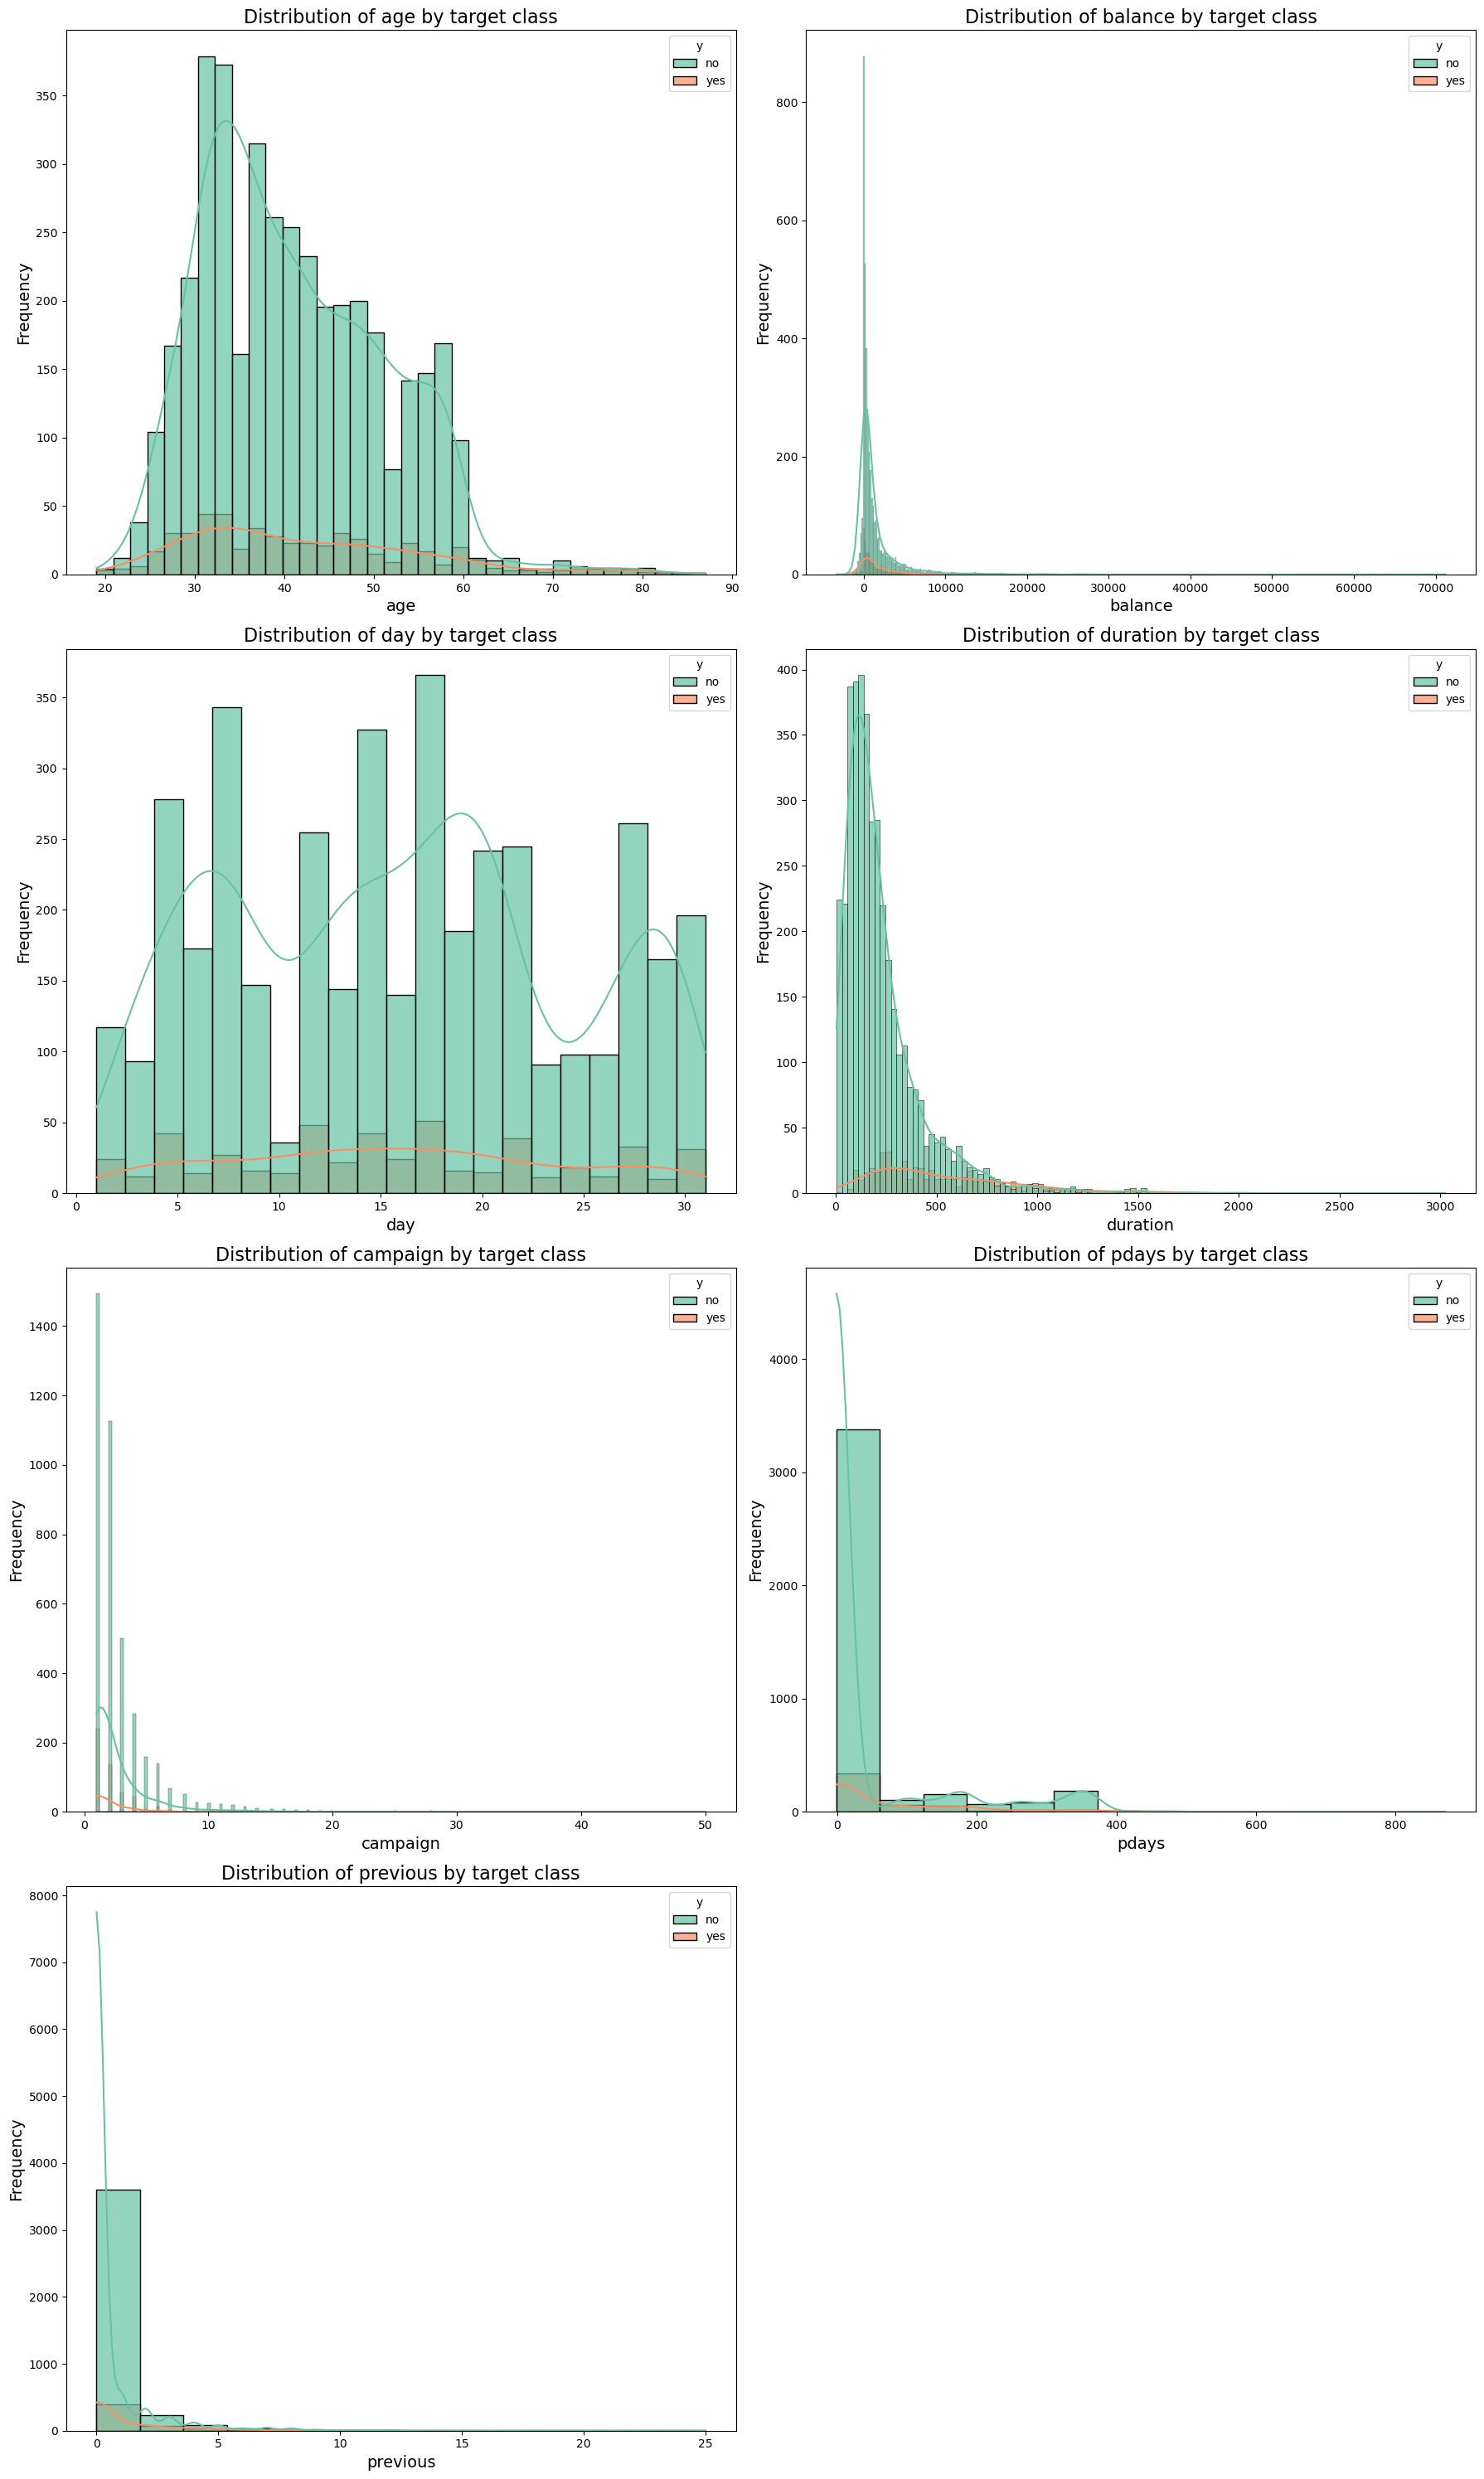

In [14]:
# Define numerical attributes and the target class
numerical_attributes = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Set up subplots in a grid with 2 columns
num_plots = len(numerical_attributes)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 30))

# Plot distribution of each numerical attribute using histograms
for i, attribute in enumerate(numerical_attributes):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(data=data, x=attribute, hue='y', kde=True, ax=axes[row, col], palette='Set2', alpha=0.7)
    axes[row, col].set_title(f'Distribution of {attribute} by target class', fontsize=16)
    axes[row, col].set_xlabel(attribute, fontsize=14)
    axes[row, col].set_ylabel('Frequency', fontsize=14)

# Remove empty subplots if any
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()

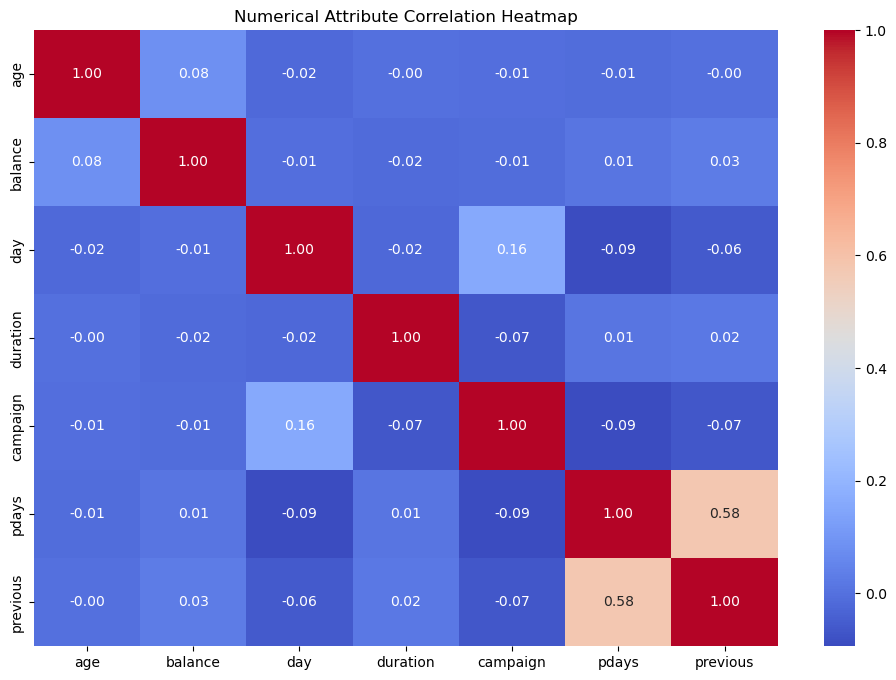

In [15]:
# Visualize attribute correlation heatmap with numerical attributes

plt.figure(figsize=(12, 8))
correlation_matrix = data[numerical_attributes].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Numerical Attribute Correlation Heatmap')
plt.show()

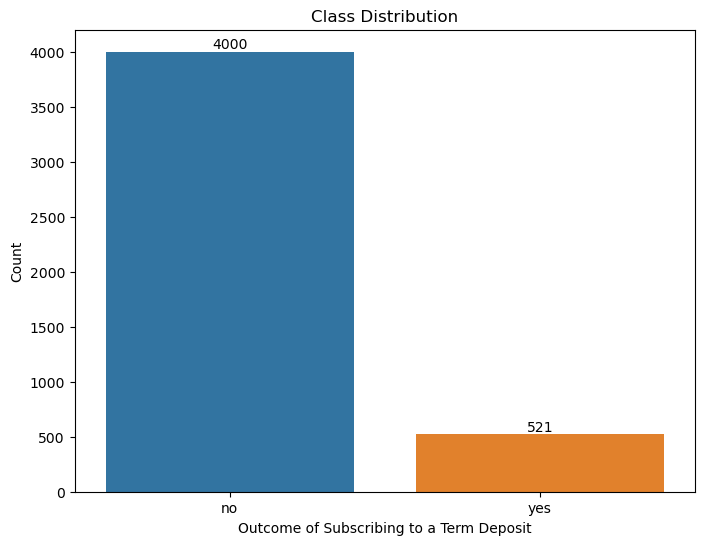

In [16]:
# 8. Class distribution
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='y', data=data)
plt.title('Class Distribution')
plt.xlabel('Outcome of Subscribing to a Term Deposit')
plt.ylabel('Count')
for i in range(len(data['y'].value_counts())):
    count = data['y'].value_counts().values[i]
    plt.text(i, count, str(count), ha = 'center', va = 'bottom')

plt.show()

### Feature Selection

In [17]:
# c) Feature Selection and Analysis
# 1.Loading and Preparing the Dataset
# Load the dataset
data = pd.read_csv('bank.csv', delimiter=';')

# Assuming 'duration' and 'y' are not in the dataset
data = data.drop(columns=['duration'])
X = data.drop(columns=['y'])
y = data['y']

# Split the data into numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Encode categorical variables
label_encoders = {}
for column in categorical_features:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])

print(X.describe())


               age          job      marital    education      default  \
count  4521.000000  4521.000000  4521.000000  4521.000000  4521.000000   
mean     41.170095     4.411192     1.147755     1.231365     0.016810   
std      10.576211     3.255716     0.599650     0.748744     0.128575   
min      19.000000     0.000000     0.000000     0.000000     0.000000   
25%      33.000000     1.000000     1.000000     1.000000     0.000000   
50%      39.000000     4.000000     1.000000     1.000000     0.000000   
75%      49.000000     7.000000     2.000000     2.000000     0.000000   
max      87.000000    11.000000     2.000000     3.000000     1.000000   

            balance      housing         loan      contact          day  \
count   4521.000000  4521.000000  4521.000000  4521.000000  4521.000000   
mean    1422.657819     0.566025     0.152842     0.652289    15.915284   
std     3009.638142     0.495676     0.359875     0.901498     8.247667   
min    -3313.000000     0.000000 

In [18]:
# 2. Applying Statistical Tests
# Prepare to collect p-values
p_values = {}

# Calculate p-values for numerical features using ANOVA
anova_results = f_classif(X[numerical_features], y)
for feature, p_value in zip(numerical_features, anova_results[1]):
    p_values[feature] = round(p_value, 10)

# Calculate p-values for categorical features using Chi-Square test
chi2_results = chi2(X[categorical_features], y)
for feature, p_value in zip(categorical_features, chi2_results[1]):
    p_values[feature] = round(p_value, 10)

# Combine p-values into a single DataFrame
p_values_data = pd.DataFrame(list(p_values.items()), columns=['Feature', 'p-value'])
p_values_data = p_values_data.sort_values(by='p-value', ascending=True)
p_values_data.reset_index(drop=True, inplace=True)

# 3. Comparing P-values
# Print the p-values
print("P-values of features:")
print(p_values_data)

# Select top 5 features with the lowest p-values
selected_features = p_values_data.head(5)
print("Selected features based on p-values:")
print(selected_features)

# Extract the top features for the heatmap
top_features = selected_features['Feature'].tolist()

P-values of features:
      Feature   p-value
0       pdays  0.000000
1    previous  0.000000
2     contact  0.000000
3     housing  0.000004
4        loan  0.000013
5    campaign  0.000039
6       month  0.000447
7    poutcome  0.000571
8         age  0.002425
9         job  0.004295
10  education  0.051171
11    balance  0.228716
12        day  0.449735
13    marital  0.571369
14    default  0.930792
Selected features based on p-values:
    Feature   p-value
0     pdays  0.000000
1  previous  0.000000
2   contact  0.000000
3   housing  0.000004
4      loan  0.000013


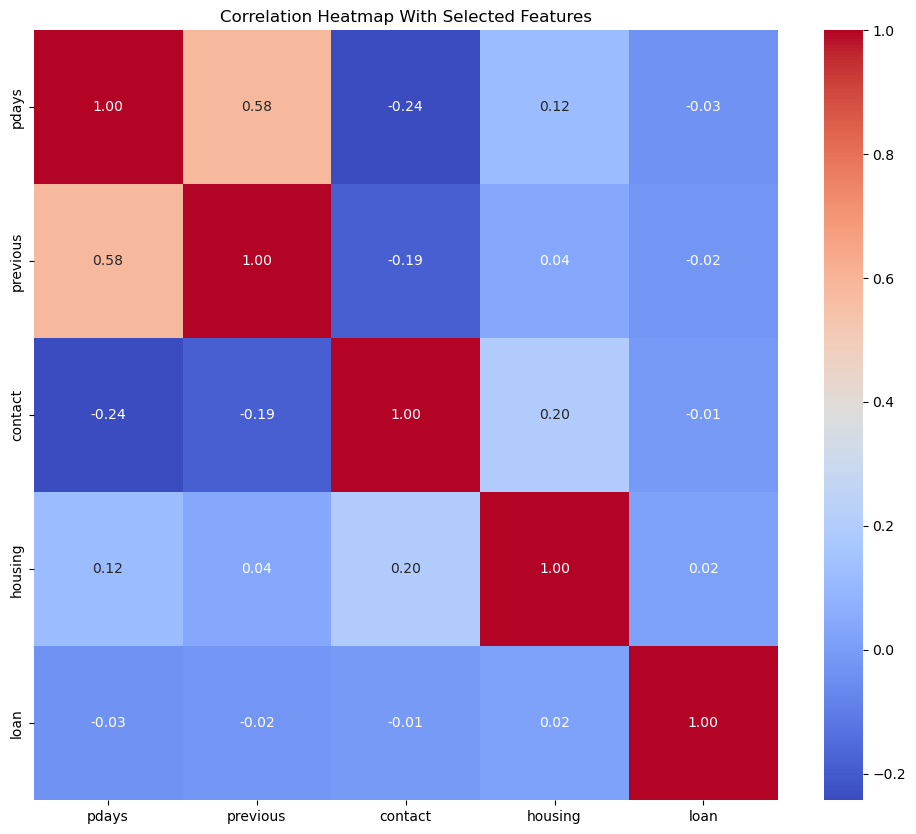

The list of selected features:
['pdays', 'previous', 'contact', 'housing', 'loan']


In [19]:
# 4. Evaluation Correlation Coefficient with Selected Attributes
# Plot the correlation heatmap for the reduced dataset
reduced_X = X[top_features]
reduced_correlation_matrix = reduced_X.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(reduced_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap With Selected Features')
plt.show()

# Verify the reduced feature set
print("The list of selected features:")
print(reduced_X.columns.tolist())

Selected features based on p-values:
['contact', 'campaign', 'pdays', 'housing', 'loan']


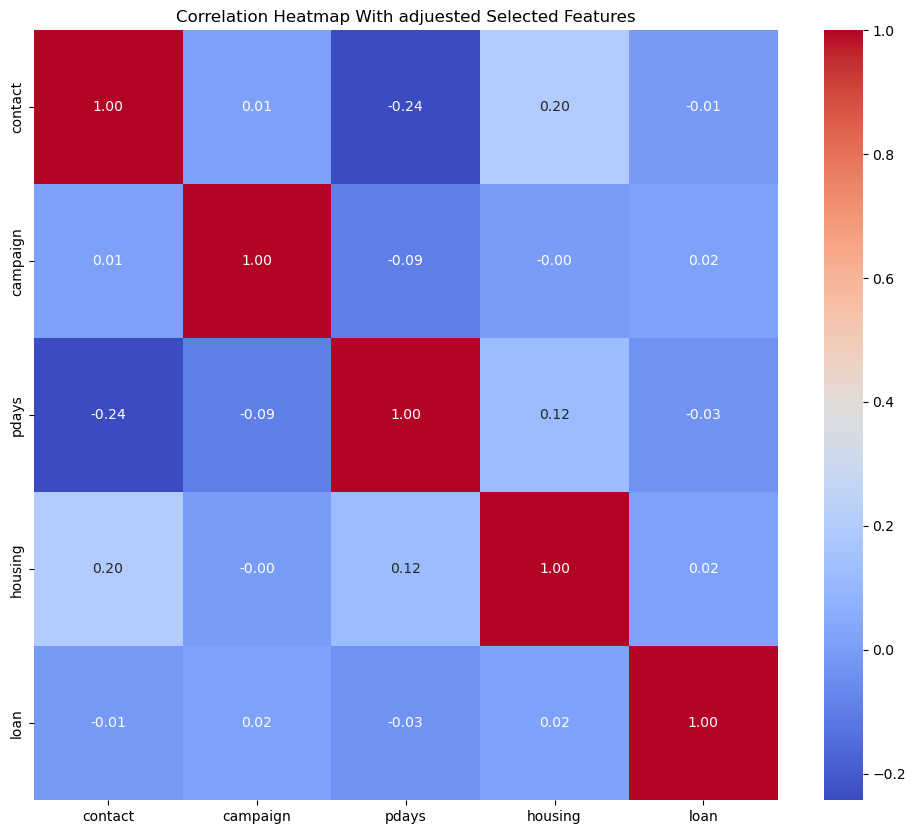

The list of adjuested selected features:
['contact', 'campaign', 'pdays', 'housing', 'loan']


In [20]:
# 5. Adjust Selected Features and Evaluation
# Remove highly correlated feature (previous) then add 6th lowest p-value feature (campaign)
selected_features = ['contact', 'campaign', 'pdays', 'housing', 'loan']
print("Selected features based on p-values:")
print(selected_features)

# Extract the top features for the heatmap
top_features = selected_features

# Plot the correlation heatmap for the reduced dataset
reduced_X = X[top_features]
reduced_correlation_matrix = reduced_X.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(reduced_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap With adjuested Selected Features')
plt.show()

# Verify the reduced feature set
print("The list of adjuested selected features:")
print(reduced_X.columns.tolist())

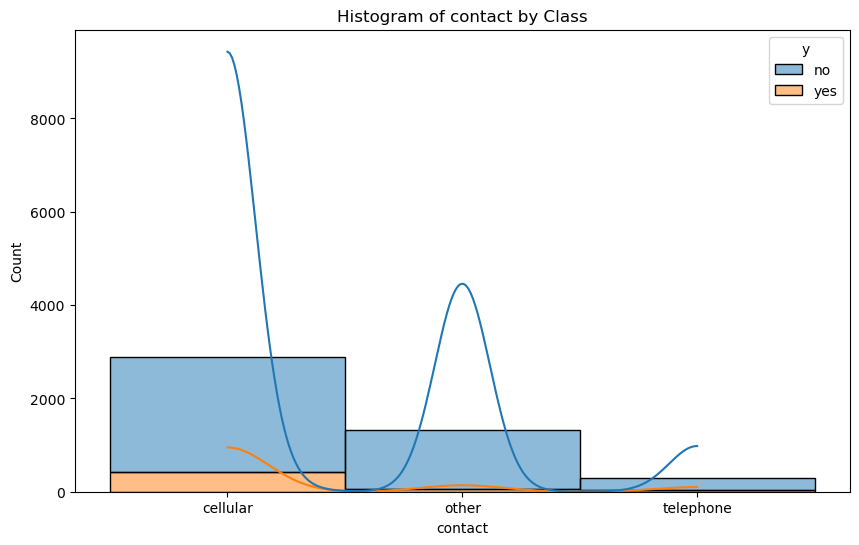

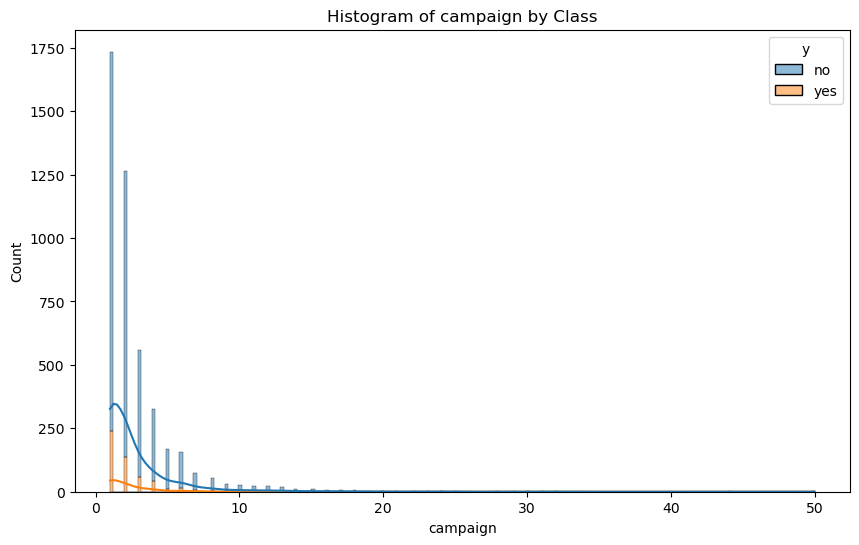

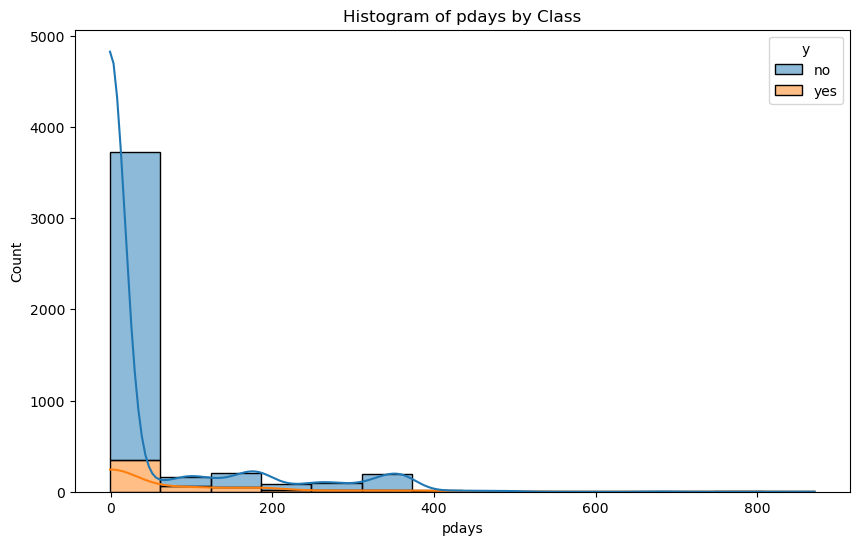

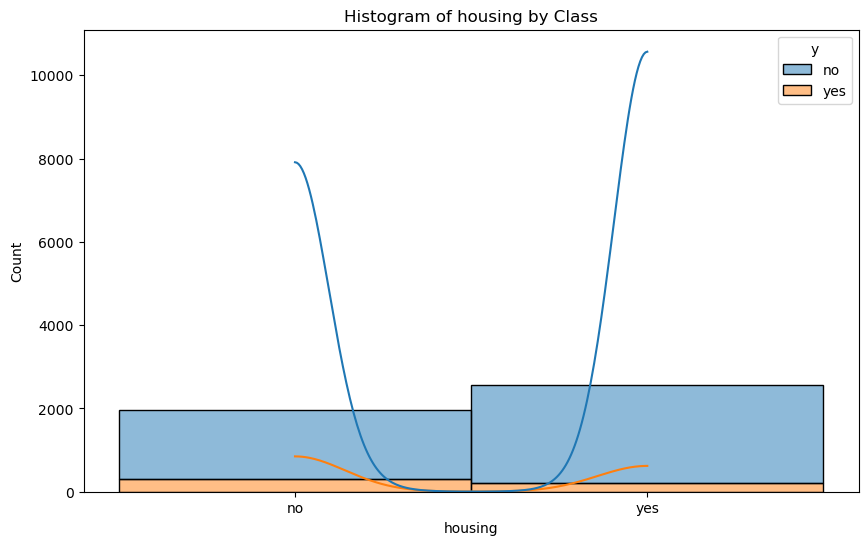

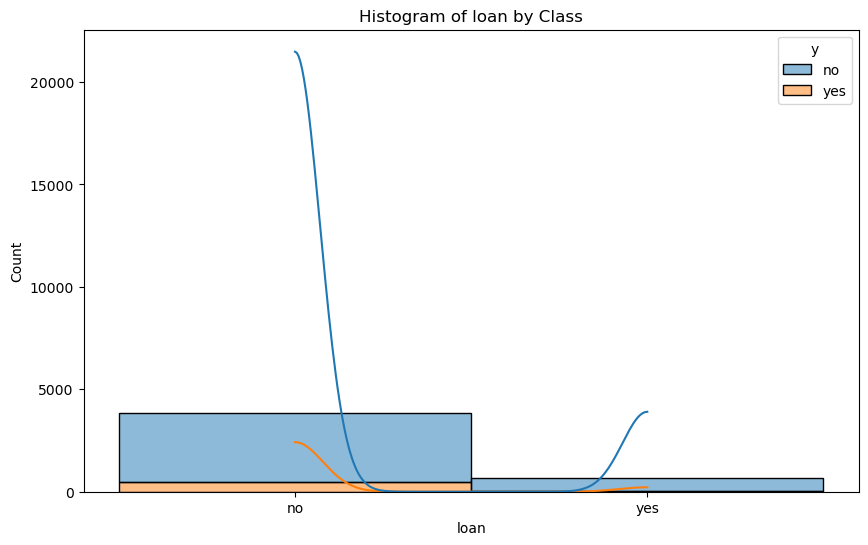

In [21]:
# c) Analysis of The Feature Selection by Target Class
 
# Handle "unknown" values
def handle_unknown(data):
    data['education'] = data['education'].replace('unknown', 'no education')
    data['job'] = data['job'].replace('unknown', 'no mention')
    data['contact'] = data['contact'].replace('unknown', 'other')
    data['poutcome'] = data['poutcome'].replace('unknown', 'no record')
    return data

data = handle_unknown(data)

# Breakdown analysis and distribution plots for each of the top 5 features
for feature in top_features:
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x=feature, hue=y, multiple="stack", kde=True)
    plt.title(f'Histogram of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

## Naive Bayes Model

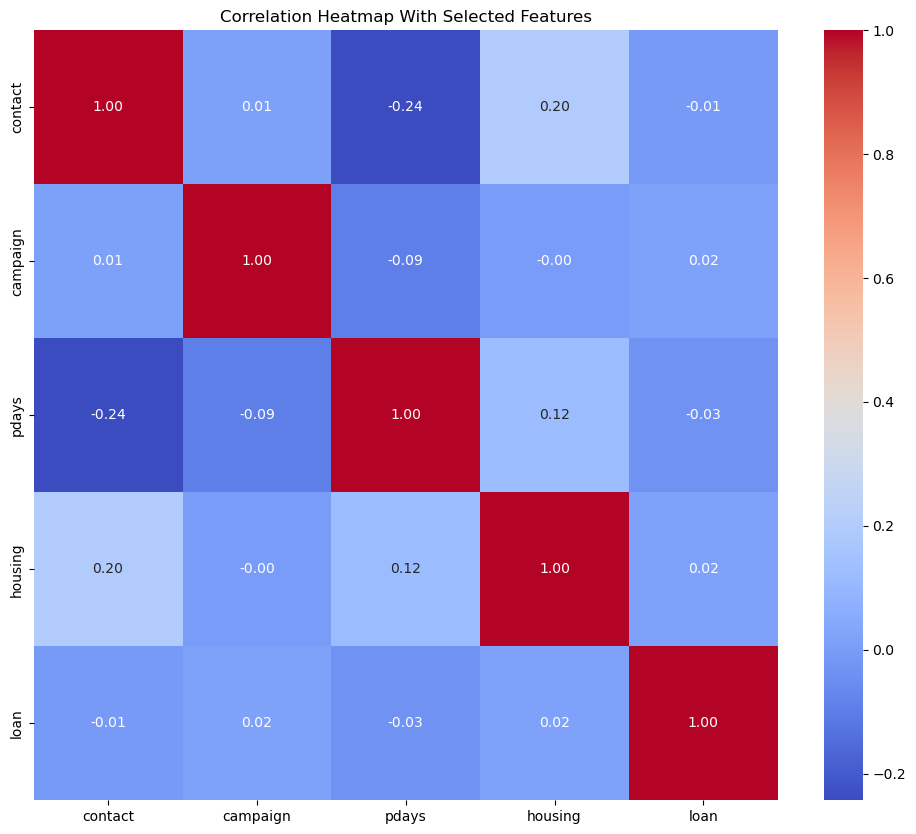

In [22]:
# d) Independce Assumption in Naive Bayes
# Plot the correlation heatmap for the reduced dataset

reduced_correlation_matrix = reduced_X.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(reduced_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap With Selected Features')
plt.show()

Accuracy: 0.8386145910095799

Confusion Matrix:
 [[1121   80]
 [ 139   17]]

Classification Report:
               precision    recall  f1-score   support

          no       0.89      0.93      0.91      1201
         yes       0.18      0.11      0.13       156

    accuracy                           0.84      1357
   macro avg       0.53      0.52      0.52      1357
weighted avg       0.81      0.84      0.82      1357



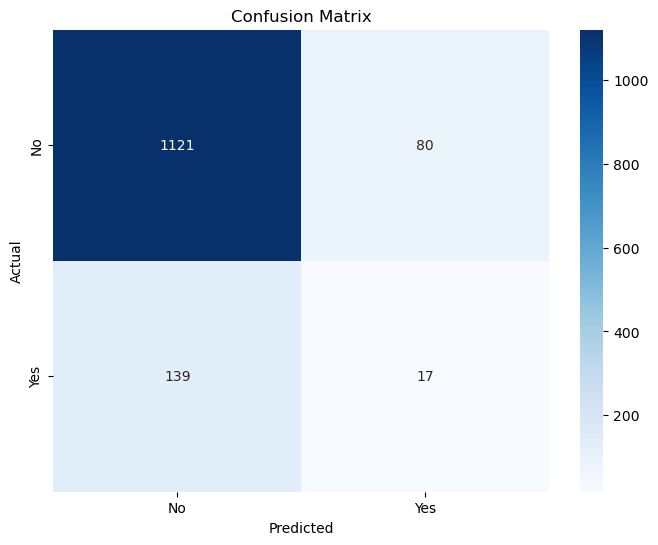

In [23]:
# e) Naive Bayes Model Building and Evaluation
# Confusion Matrix and Classification Report of Naive Bayes

from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler


data = pd.read_csv('bank.csv', delimiter=';')

# Split the data into features (X) and target (y)
X = data.drop(columns=['y'])
y = data['y']  # Target variable

categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Encode categorical variables
label_encoders = {}
for column in categorical_features:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])

X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features (GaussianNB works better with standardized features)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the Naïve Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gnb.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

K-Fold Cross Validation Scores:
Fold 1: 0.8432671081677704
Fold 2: 0.8097345132743363
Fold 3: 0.838495575221239
Fold 4: 0.8407079646017699
Fold 5: 0.8517699115044248
Fold 6: 0.8252212389380531
Fold 7: 0.8517699115044248
Fold 8: 0.834070796460177
Fold 9: 0.8407079646017699
Fold 10: 0.8362831858407079
Mean Accuracy: 0.8372028170114673


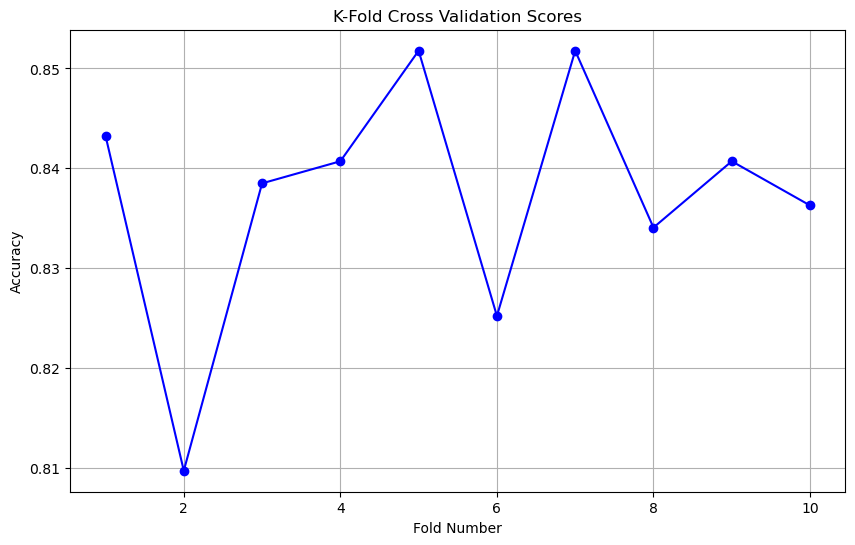

In [24]:
# Evaluation with K-Fold Cross Validation

from sklearn.model_selection import StratifiedKFold

# Initialize the StratifiedKFold with 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize Naive Bayes model
gnb = GaussianNB()

# Arrays to store the scores
cv_scores = []
conf_matrices = []
class_reports = []

# Stratified K-Fold Cross Validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Standardize the features
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train the model
    gnb.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = gnb.predict(X_test)
    
    # Store accuracy
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores.append(accuracy)
    
    # Store confusion matrix and classification report
    conf_matrices.append(confusion_matrix(y_test, y_pred))
    class_reports.append(classification_report(y_test, y_pred, output_dict=True))

# Print the K-Fold Cross Validation Scores and Mean Accuracy
print("K-Fold Cross Validation Scores:")
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: {score}")
print("Mean Accuracy:", np.mean(cv_scores))

# Plot the K-Fold Cross Validation Scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='-', color='b')
plt.title('K-Fold Cross Validation Scores')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## KNN model

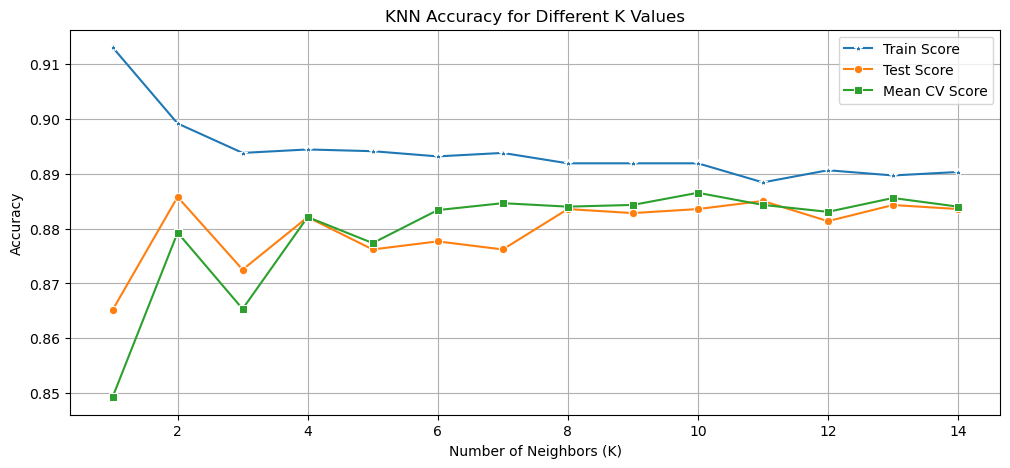

K = 1: Test Score = 0.8651
K = 2: Test Score = 0.8858
K = 3: Test Score = 0.8725
K = 4: Test Score = 0.8821
K = 5: Test Score = 0.8762
K = 6: Test Score = 0.8777
K = 7: Test Score = 0.8762
K = 8: Test Score = 0.8836
K = 9: Test Score = 0.8828
K = 10: Test Score = 0.8836
K = 11: Test Score = 0.8850
K = 12: Test Score = 0.8814
K = 13: Test Score = 0.8843
K = 14: Test Score = 0.8836

Best K = 2
Best Accuracy: 0.8858
Best Confusion Matrix:
[[1190   11]
 [ 144   12]]
Best Classification Report:
              precision    recall  f1-score   support

          no       0.89      0.99      0.94      1201
         yes       0.52      0.08      0.13       156

    accuracy                           0.89      1357
   macro avg       0.71      0.53      0.54      1357
weighted avg       0.85      0.89      0.85      1357



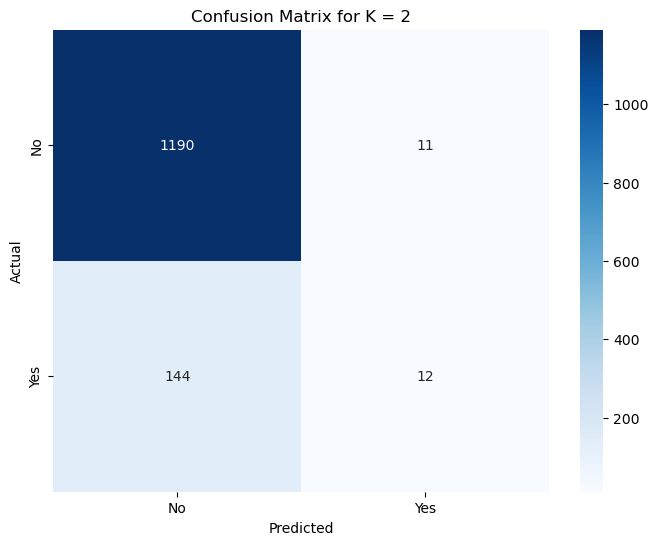

K-Fold Cross Validation Scores when K = 2:
Fold 1: 0.8770
Fold 2: 0.8833
Fold 3: 0.8738
Fold 4: 0.8738
Fold 5: 0.8861
Fold 6: 0.8924
Fold 7: 0.8513
Fold 8: 0.8861
Fold 9: 0.8829
Fold 10: 0.8861
Mean Accuracy: 0.8792696561913507


In [25]:
# f) KNN Model Building and Evaluation
# Import necessary libraries
from sklearn.neighbors import KNeighborsClassifier

# Load the dataset
data = pd.read_csv('bank.csv', delimiter=';')

# Select the top 5 features (you may need to update the feature names if they have been encoded)


# Split the data into features (X) and target (y)
X = data[selected_features]
y = data['y']  # Target variable

# Encode categorical attributes
label_encoders = {}
categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])


# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize lists to store evaluation metrics
train_scores = []
test_scores = []
cv_scores_list = []

# Define a range of K values
k_range = range(1, 15)

# Initialize StratifiedKFold for cross-validation with stratification
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Loop through different K values
for k in k_range:
    # Initialize and train the KNN model
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Perform K-Fold Cross Validation and store the mean score
    cv_scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring='accuracy')
    cv_scores_list.append(cv_scores.mean())
    
    # Evaluate the model's performance on training and test sets
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

# Plot the accuracy scores for different K values
plt.figure(figsize=(12, 5))
sns.lineplot(x=k_range, y=train_scores, marker='*', label='Train Score')
sns.lineplot(x=k_range, y=test_scores, marker='o', label='Test Score')
sns.lineplot(x=k_range, y=cv_scores_list, marker='s', label='Mean CV Score')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for Different K Values')
plt.legend()
plt.grid(True)
plt.show()

# Print the accuracy scores for each K value
for k, score in zip(k_range, test_scores):
    print(f"K = {k}: Test Score = {score:.4f}")

# Select the best K based on the highest test accuracy
best_k = k_range[test_scores.index(max(test_scores))]

# Train the KNN model with the best K value and evaluate again
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
best_y_pred = best_knn.predict(X_test)

# Evaluate the best KNN model
best_accuracy = best_knn.score(X_test, y_test)
best_conf_matrix = confusion_matrix(y_test, best_y_pred)
best_class_report = classification_report(y_test, best_y_pred)

print(f"\nBest K = {best_k}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print("Best Confusion Matrix:")
print(best_conf_matrix)
print("Best Classification Report:")
print(best_class_report)

# Plot the best confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title(f'Confusion Matrix for K = {best_k}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Perform K-Fold Cross Validation for K=2 and print the scores
cv_scores = cross_val_score(best_knn, X_train, y_train, cv=cv, scoring='accuracy')
print("K-Fold Cross Validation Scores when K = 2:")
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: {score:.4f}")
print("Mean Accuracy:", np.mean(cv_scores))

## Part B

### MLP model

In [4]:
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
df = pd.read_csv('bank.csv', sep=';')

print(df)

      age            job  marital  education default  balance housing loan  \
0      30     unemployed  married    primary      no     1787      no   no   
1      33       services  married  secondary      no     4789     yes  yes   
2      35     management   single   tertiary      no     1350     yes   no   
3      30     management  married   tertiary      no     1476     yes  yes   
4      59    blue-collar  married  secondary      no        0     yes   no   
...   ...            ...      ...        ...     ...      ...     ...  ...   
4516   33       services  married  secondary      no     -333     yes   no   
4517   57  self-employed  married   tertiary     yes    -3313     yes  yes   
4518   57     technician  married  secondary      no      295      no   no   
4519   28    blue-collar  married  secondary      no     1137      no   no   
4520   44   entrepreneur   single   tertiary      no     1136     yes  yes   

       contact  day month  duration  campaign  pdays  previous 

In [5]:
# Handling “unknown” data in categorical columns.

# Handle "unknown" values
def handle_unknown(df):
    df['education'] = df['education'].replace('unknown', 'no education')
    df['job'] = df['job'].replace('unknown', 'no mention')
    df['contact'] = df['contact'].replace('unknown', 'other')
    df['poutcome'] = df['poutcome'].replace('unknown', 'no record')
    return df

df = handle_unknown(df)

In [ ]:
# another alternative method dealing with missing values showing below
# due to the imbalanced dataset, prediciting and replacing unknown data will increase the risk of overfitting so the method won't be chosen

# Replace "unknown" with NaN to handle missing values
df = df.replace("unknown", np.nan)

# Loop through all columns to handle missing values
for column in df.columns:
    if df[column].isna().any():
        # Separate known and unknown values
        known = df.dropna(subset=[column])
        unknown = df[df[column].isna()]
        
        # If there are unknown values to predict
        if not unknown.empty:
            features = known.drop(columns=[column])
            target = known[column]
            
            # Convert categorical features to numerical
            features_encoded = pd.get_dummies(features)
            unknown_features_encoded = pd.get_dummies(unknown.drop(columns=[column]))
            
            # Align the columns of the encoded unknown features with the known features
            unknown_features_encoded = unknown_features_encoded.reindex(columns=features_encoded.columns, fill_value=0)
            
            # Train the RandomForestClassifier
            clf = RandomForestClassifier()
            clf.fit(features_encoded, target)
            
            # Predict the missing values
            predictions = clf.predict(unknown_features_encoded)
            
            # Fill the missing values in the original dataframe
            df.loc[df[column].isna(), column] = predictions

k=1: Mean CV Accuracy=0.8837, Test Set Accuracy=0.8850
k=2: Mean CV Accuracy=0.8846, Test Set Accuracy=0.8850
k=3: Mean CV Accuracy=0.8846, Test Set Accuracy=0.8850
k=4: Mean CV Accuracy=0.8846, Test Set Accuracy=0.8850
k=5: Mean CV Accuracy=0.8846, Test Set Accuracy=0.8850
k=6: Mean CV Accuracy=0.8843, Test Set Accuracy=0.8850
k=7: Mean CV Accuracy=0.8846, Test Set Accuracy=0.8850
k=8: Mean CV Accuracy=0.8843, Test Set Accuracy=0.8850
k=9: Mean CV Accuracy=0.8846, Test Set Accuracy=0.8850
k=10: Mean CV Accuracy=0.8834, Test Set Accuracy=0.8843
k=11: Mean CV Accuracy=0.8846, Test Set Accuracy=0.8850
k=12: Mean CV Accuracy=0.8846, Test Set Accuracy=0.8850
k=13: Mean CV Accuracy=0.8846, Test Set Accuracy=0.8858
k=14: Mean CV Accuracy=0.8840, Test Set Accuracy=0.8850
k=15: Mean CV Accuracy=0.8846, Test Set Accuracy=0.8850
k=16: Mean CV Accuracy=0.8818, Test Set Accuracy=0.8850
k=17: Mean CV Accuracy=0.8831, Test Set Accuracy=0.8850
k=18: Mean CV Accuracy=0.8843, Test Set Accuracy=0.8850
k

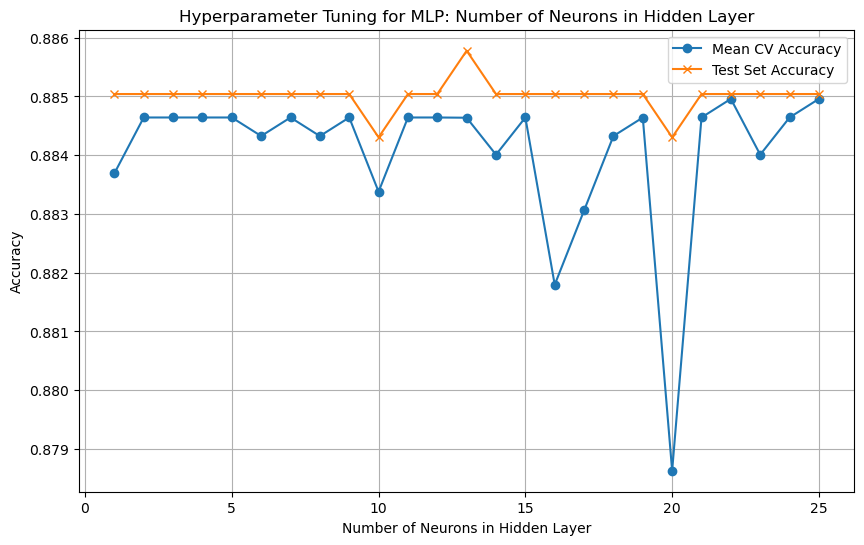

In [5]:
selected_features = ['contact', 'campaign', 'pdays', 'housing', 'loan']
# Split the data into features (X) and target (y)
X = df[selected_features]
y = df['y']  # Target variable

# Encode categorical attributes
label_encoders = {}
categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

    
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define the range of k values to try
k_values = range(1, 26)

mean_accuracies = []
test_accuracies = []

# Applied stratifiedKfold to help the training data balanced under the unbalanced data
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Try all k values to find the best one
for k in k_values:
    mlp = MLPClassifier(hidden_layer_sizes=(k,), random_state=42)
    
    # Cross-validation scores
    scores = cross_val_score(mlp, X_train, y_train, cv=skf)
    mean_accuracies.append(np.mean(scores))
    
    # Train the model on the full training set
    mlp.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = mlp.predict(X_test)
    
    # Calculate the accuracy on the test set
    accuracy = accuracy_score(y_test, y_pred)
    test_accuracies.append(accuracy)

# Print the mean cross-validation accuracies and test set accuracies for each k
for k, mean_accuracy, test_accuracy in zip(k_values, mean_accuracies, test_accuracies):
    print(f"k={k}: Mean CV Accuracy={mean_accuracy:.4f}, Test Set Accuracy={test_accuracy:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_accuracies, marker='o', label='Mean CV Accuracy')
plt.plot(k_values, test_accuracies, marker='x', label='Test Set Accuracy')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Accuracy')
plt.title('Hyperparameter Tuning for MLP: Number of Neurons in Hidden Layer')
plt.legend()
plt.grid()
plt.show()

In [6]:
# find best k and print the accuracy
best_k_index = np.argmax(test_accuracies)
best_k = k_values[best_k_index]
best_accuracy = test_accuracies[best_k_index]

print("Best number of neurons in the hidden layer:", best_k)
print("Corresponding highest accuracy:", best_accuracy)

Best number of neurons in the hidden layer: 13
Corresponding highest accuracy: 0.8857774502579219


In [8]:
k = 13

mlp = MLPClassifier(hidden_layer_sizes=(k,), random_state=42)

# train the data
mlp.fit(X_train, y_train)

# predict
mlp_predict = mlp.predict(X_test)

mlp_predict_proba = mlp.predict_proba(X_test)[:, 1]

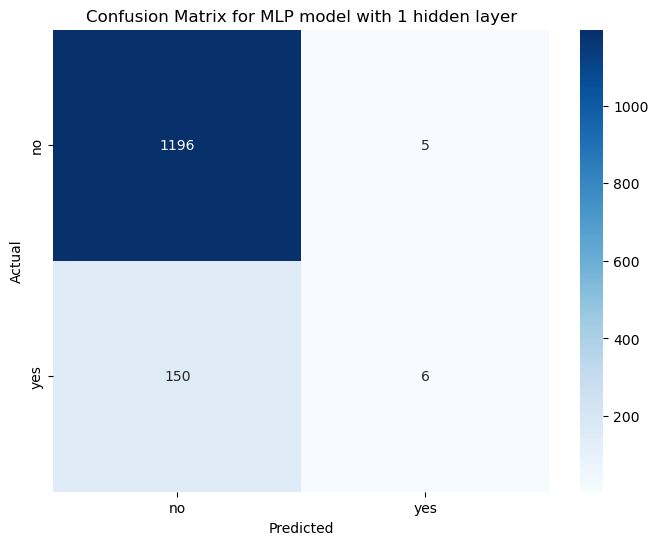


Classification Report:
               precision    recall  f1-score   support

          no       0.89      1.00      0.94      1201
         yes       0.55      0.04      0.07       156

    accuracy                           0.89      1357
   macro avg       0.72      0.52      0.51      1357
weighted avg       0.85      0.89      0.84      1357


Accuracy Score:  0.8857774502579219
Precision: 0.5454545454545454
Recall: 0.038461538461538464
F1 score: 0.0718562874251497


In [9]:
best_k = 13  # the best result found earlier

# create the model and train it
mlp_model_1_layer = MLPClassifier(hidden_layer_sizes=(best_k,), random_state=42)
mlp_model_1_layer.fit(X_train, y_train)

# predict using test data
y_pred_mlp_1_layer = mlp_model_1_layer.predict(X_test)

# coculate confusion matrix
conf_matrix_mlp_1_layer = confusion_matrix(y_test, y_pred_mlp_1_layer)

# print out
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp_1_layer, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MLP model with 1 hidden layer')
plt.xticks(ticks=[0.5, 1.5], labels=['no', 'yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['no', 'yes'])

plt.show()



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_mlp_1_layer)

class_report = classification_report(y_test, y_pred_mlp_1_layer)

# Print the evaluation metrics

print("\nClassification Report:\n", class_report)
print("\nAccuracy Score: ", accuracy)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred_mlp_1_layer)
precision = precision_score(y_test, y_pred_mlp_1_layer, pos_label='yes')
recall = recall_score(y_test, y_pred_mlp_1_layer, pos_label='yes')
f1 = f1_score(y_test, y_pred_mlp_1_layer, pos_label='yes')

# Print the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

In [10]:
#test to find best iteration number

iterations = [10, 50, 100, 200, 500, 1000]


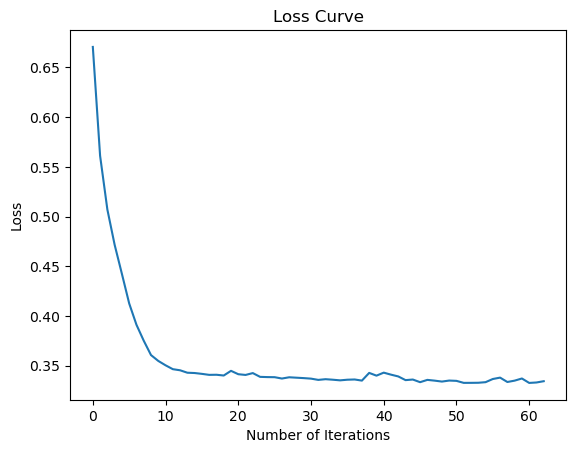

In [11]:
# plotting Loss Curve
loss_values = mlp.loss_curve_
plt.plot(loss_values)
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

Best test set accuracy: 0.8865143699336773
Best neurons allocation: (18, 7)
   Neurons Allocation  Mean CV Accuracy  Test Set Accuracy
0             (1, 24)          0.884641           0.885041
1             (2, 23)          0.884641           0.885041
2             (3, 22)          0.879895           0.885041
3             (4, 21)          0.884325           0.885041
4             (5, 20)          0.884641           0.885041
5             (6, 19)          0.884641           0.885041
6             (7, 18)          0.884641           0.885041
7             (8, 17)          0.884641           0.885041
8             (9, 16)          0.884325           0.884304
9            (10, 15)          0.884325           0.885041
10           (11, 14)          0.884326           0.885041
11           (12, 13)          0.883695           0.885041
12           (13, 12)          0.884641           0.885041
13           (14, 11)          0.884641           0.885041
14           (15, 10)          0.884641

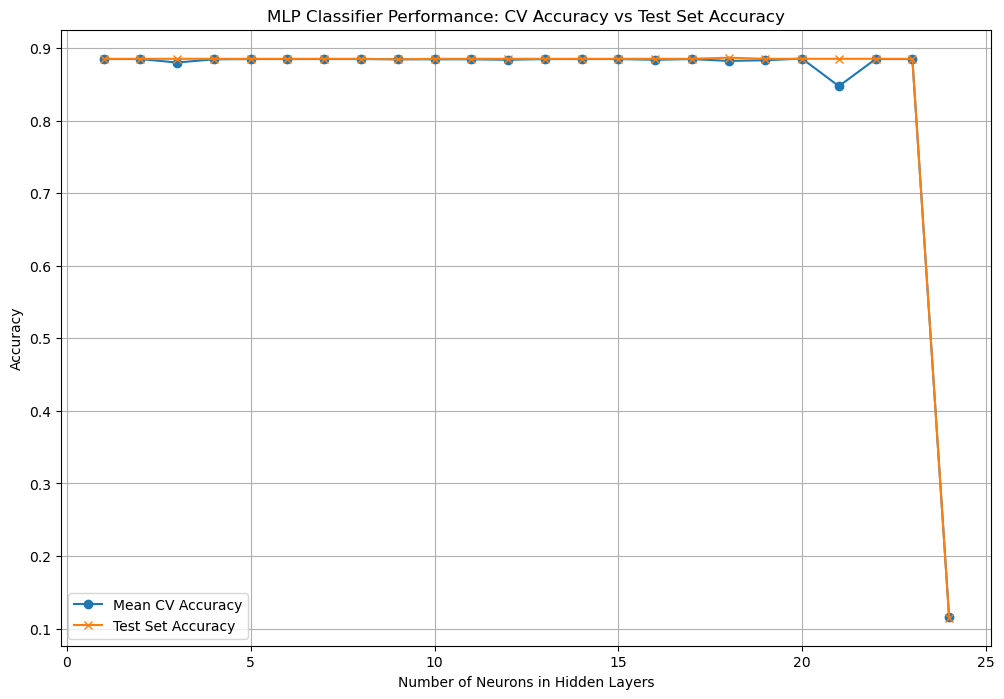

In [12]:

max_neurons = 25

# Initialize variables to record the highest classification accuracy and corresponding neuron allocation scheme
best_accuracy = 0
best_neurons_allocation = None

# Initialize results list
results = []

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Loop through neuron allocation schemes
for i in range(1, max_neurons):
    # Create Multi-Layer Perceptron model
    mlp = MLPClassifier(hidden_layer_sizes=(i, max_neurons - i), max_iter=40, random_state=42)

    # Cross-validation scores
    cv_scores = cross_val_score(mlp, X_train, y_train, cv=skf)
    mean_cv_accuracy = np.mean(cv_scores)
    
    # Train the model on the full training set
    mlp.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = mlp.predict(X_test)
    
    # Calculate test set accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    
    # Append the results to the list
    results.append(((i, max_neurons - i), mean_cv_accuracy, test_accuracy))
    
    # Update the highest classification accuracy and corresponding neuron allocation if the current accuracy is higher
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_neurons_allocation = (i, max_neurons - i)

# Print the best classification accuracy and corresponding neuron allocation
print("Best test set accuracy:", best_accuracy)
print("Best neurons allocation:", best_neurons_allocation)

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Neurons Allocation', 'Mean CV Accuracy', 'Test Set Accuracy'])

# Print the results table
print(results_df)

# Optionally, plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(range(1, max_neurons), results_df['Mean CV Accuracy'], marker='o', label='Mean CV Accuracy')
plt.plot(range(1, max_neurons), results_df['Test Set Accuracy'], marker='x', label='Test Set Accuracy')
plt.xlabel('Number of Neurons in Hidden Layers')
plt.ylabel('Accuracy')
plt.title('MLP Classifier Performance: CV Accuracy vs Test Set Accuracy')
plt.legend()
plt.grid()
plt.show()

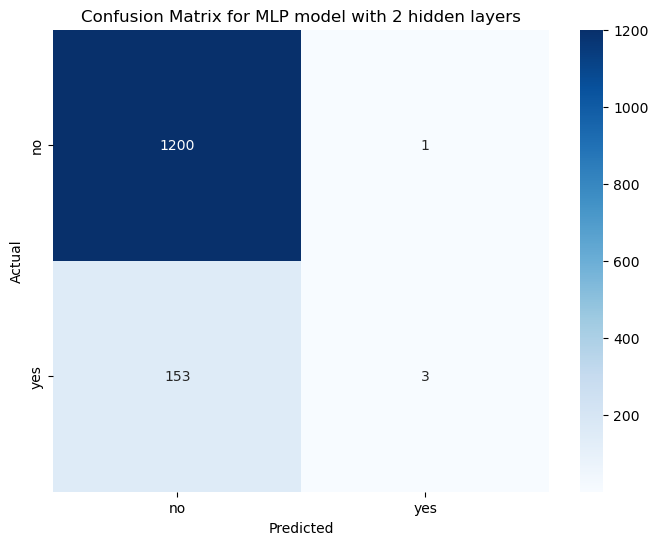


Classification Report:
               precision    recall  f1-score   support

          no       0.89      1.00      0.94      1201
         yes       0.75      0.02      0.04       156

    accuracy                           0.89      1357
   macro avg       0.82      0.51      0.49      1357
weighted avg       0.87      0.89      0.84      1357

Accuracy: 0.8865143699336773
Precision: 0.75
Recall: 0.019230769230769232
F1 score: 0.0375


In [13]:

best_neurons_allocation = (18, 7)  # the best result found earlier

mlp_model_2_layers = MLPClassifier(hidden_layer_sizes=best_neurons_allocation, random_state=42,  max_iter=40)
mlp_model_2_layers.fit(X_train, y_train)
y_pred_mlp_2_layers = mlp_model_2_layers.predict(X_test)

# 2. conculate confusion matrix
conf_matrix_mlp_2_layers = confusion_matrix(y_test, y_pred_mlp_2_layers)

# 3. print
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp_2_layers, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MLP model with 2 hidden layers')

plt.xticks(ticks=[0.5, 1.5], labels=['no', 'yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['no', 'yes'])
plt.show()


from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_mlp_2_layers)

# Calculate classification report
class_report = classification_report(y_test, y_pred_mlp_2_layers)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_mlp_2_layers, pos_label='yes')

# Calculate precision score
precision = precision_score(y_test, y_pred_mlp_2_layers, pos_label='yes')

# Calculate recall score
recall = recall_score(y_test, y_pred_mlp_2_layers, pos_label='yes')

# Print the evaluation metrics
print("\nClassification Report:\n", class_report)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)